# Main notebook for "Fiscal and Monetary Policy with Heterogeneous Agents"
This notebook reads in the HA calibration in `hh_params.json` produced by `Annual Review hh calibration.ipynb`, and produces the main results of the paper, including Figures 2 and 3. It uses the household blocks (for the HA, TA, and RA models) specified in the `household.py` module, included in the same repository.

Start with preliminary imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import json

import sequence_jacobian as sj 

from household import hh_ha, hh_ta, hh_ra

Uncomment the second line below if you want plots with exactly the same style as in the paper (note that this may take longer to render or have compatibility issues):

In [2]:
plt.rcParams.update({'font.size': 10, 'font.family': 'serif', 'figure.figsize': (4, 3)})
#plt.rcParams.update({'text.usetex': True, 'font.serif': 'Palatino'})

# 1. Blocks for general equilibrium economy
Household blocks are specified in `household.py`. We now define blocks for the rest of the economy.

#### Production

In [3]:
@sj.simple
def production(Y, mu):
    """Split aggregate income into pre-tax wage and dividends income"""
    N = Y               # production technology (to first order, i.e. ignoring any Calvo or Rotemberg distortion)
    wN = Y / mu
    div = Y - wN
    return N, wN, div

#### Government bond structure
To accommodate all scenarios we're considering in the paper, we'll need to define several ways to calculate the real ex-post return on government bonds, which we call `r_post_bonds`. Our default is the first case, with real short-term bonds.

For all cases, we'll also return $q^{bond}$, which gives the end-of-period price of a debt security that pays 1 (in real terms) tomorrow—either a short-term bond that fully matures and pays 1 tomorrow (in which case the value today is $q^{bond}=1/(1+r)$), or a long-term bond that pays a coupon of 1 tomorrow (in which case the value today is higher). We'll need this for our default fiscal rule in the monetary shock case, which keeps the value paid out tomorrow constant in real terms.

In [4]:
@sj.simple
def real_ST_bonds(r_ante):
    """Bond returns if bonds are short term and real (our default assumption)"""
    r_post_bonds = r_ante(-1)
    qbond = 1/(1 + r_ante)
    return r_post_bonds, qbond

@sj.simple
def nom_ST_bonds(r_ante, pi):
    """Bond returns if bonds are short term and nominal"""
    # real return adjusted downward by any excess of expected over actual inflation
    pi_e = pi(1)
    r_post_bonds = (1 + r_ante(-1)) * (1 + pi_e(-1))/(1 + pi) - 1
    qbond = 1/(1 + r_ante)
    return r_post_bonds, qbond

@sj.solved(unknowns={'qbond': (0.001, 100.)}, targets=['q_res'], solver="brentq")
def real_LT_bonds(qbond, r_ante, delta):
    """Bond returns if bonds are long term and real"""
    # equation for end-of-period price q of stream of future coupons (1,delta,delta^2,...): q_res=0
    q_res = qbond - (1 + delta * qbond(+1)) / (1 + r_ante)

    # ex-post return on bonds is coupon today plus delta times value of remaining coupon stream
    # divided by yesterday's end-of-period price
    r_post_bonds = (1 + delta * qbond) / qbond(-1) - 1
    return r_post_bonds, q_res

#### Fiscal policy
The basic fiscal rule is simple: given desired paths of end-of-period debt value $B_t$ and government spending $G_t$, solve for the tax rate on all income (including labor and dividend income, which together comprise total output $Y_t$) that balances the budget. This is done in the first few lines below.

We also need several additional outputs here, though, which are used only in special cases:
1. For our implementation of Angeletos Lian Wolf ("ALW" 2024), we calculate the residual of the tax *rate* relative to an exogenously shocked path. 

2. For our implementation of either the FTPL or of a slow-moving fiscal rule that raises taxes gradually in response to higher debt, we calculate the residual of overall tax *revenue* relative to a rule that can be shocked. 

3. For our default fiscal rule in response to monetary shocks, we calculate $B_t/q_t$, which is the real amount paid at $t+1$ (the coupon for long-term debt, entire maturing bond for short-term debt), and then calculate the residual of that vs. a constant.

In all these three cases, we will ultimately solve for the path of $B_t$ that sets the relevant residual to zero.

In [5]:
@sj.simple
def fiscal(B, r_post_bonds, G, Y, wN, div, tax_rate_shock, T_shock, T_rule_coeff, qbond):
    """Calculate taxes and after-tax wage and dividend income"""
    T = (1 + r_post_bonds) * B(-1) + G - B  # total tax burden consistent with B and G
    tax_rate = T / Y                        # required tax rate
    wN_aftertax = (1 - tax_rate) * wN       # after-tax wage income
    div_aftertax = (1 - tax_rate) * div     # after-tax dividends

    # ALW (2024) rule
    tax_rate_res = tax_rate - tax_rate.ss - tax_rate_shock
    
    # Tax revenue rule (used for FTPL and alternative fiscal rule)
    T_res = T - T.ss - T_rule_coeff * (B(-1) - B.ss) - T_shock
    
    # Default fiscal rule for monetary policy: constant amount owed tomorrow
    constant_owed_res = B/qbond - B.ss/qbond.ss
    return T, tax_rate, wN_aftertax, div_aftertax, tax_rate_res, T_res, constant_owed_res

We also have a slight variation on the main case above, where any deviation of desired taxes from steady state is assessed lump-sum on the agents in the highest income state.

In [6]:
@sj.simple
def fiscal_richest(B, r_post_bonds, G, Y, wN, div):
    """Variant of above where any taxes beyond steady state are raised only on the richest"""
    Tax_total = (1 + r_post_bonds) * B(-1) + G - B  # total tax burden
    T = Tax_total.ss                                # fix standard proportional taxes at steady state level
    Tax_richest = Tax_total - T                     # remaining tax burden assessed on richest
    tax_rate = T / Y
    wN_aftertax = (1 - tax_rate) * wN
    div_aftertax = (1 - tax_rate) * div
    return T, tax_rate, wN_aftertax, div_aftertax, Tax_richest

#### EXTRA - INEQUALITY DEFINITIONS
 This new block computes the wealth inequality measure (variance of assets) in the HA model.
It requires the second moment of assets (E[a^2]) to be computed in the household block (added by us).
This matters because: 
- inequality in wealth can affect consumption and savings behavior, influencing aggregate demand and economic growth.
- fiscal and monetary policies may have different effects across the wealth distribution, impacting overall economic stability and growth.
- by adding inequality measures, we can better understand how policy shocks affect inequality over time. 

In [47]:
@sj.simple
def ha_inequality(a, a2):
    """
    a   : average assets (E[a]) per period – aggregate output from the household block
    a2  : second moment of assets (E[a^2]) per period – newly added aggregate moment

    Computes the variance of assets using Var(a) = E[a^2] – (E[a])^2.
    """
    var_a = a2 - a**2
    return {'var_a': var_a}


#### Capitalized value of firms and asset returns
The following blocks calculates the end-of-period value $p_t$ of firms, which is the capitalized value of future dividends, and then uses this to calculate both the ex-post return on firms and the ex-post return on all assets in the economy.

In [8]:
@sj.solved(unknowns={'p': (0.001,50)}, targets=['cap_cond'])
def capitalization(div_aftertax, r_ante, p):
    """Calculate end-of-period value p of firm and ex-post return on equity holdings"""
    cap_cond = p - (div_aftertax(+1) + p(+1))/(1 + r_ante)
    r_post_equity = (div_aftertax + p)/p(-1) - 1
    return r_post_equity, cap_cond

@sj.simple
def ex_post_r(r_post_equity, r_post_bonds, B, p):
    """Calculate ex-post return on all assets, combining equity and bond returns"""
    r = (p(-1) * r_post_equity + B(-1) * r_post_bonds) / (p(-1) + B(-1))
    return r

#### New Keynesian Phillips curve
The following is a standard New Keynesian Phillips curve (valid to first order), equation (2) in the article.

Note that, rather than outputing inflation directly, this block outputs the residual of the NKPC, which is then set as a target (with inflation as an unknown) in the subset of cases where we need to solve for inflation.

In [9]:
@sj.simple
def nkpc(pi, kappa, N, Y, G, beta_ave, vscale, frisch, tax_rate, mu, eis):
    """New Keynesian Phillips Curve"""
    wedge = vscale*N**(1/frisch) - (1-tax_rate) / mu * (Y-G)**(-1/eis) # using C = Y-G
    nkpc_res = kappa * wedge + beta_ave * pi(+1) - pi
    return nkpc_res

#### Taylor rule
In most experiments, we set the path of real rates exogenously, but when we use a Taylor rule instead (either active or, in the FTPL case, passive), we'll add this block:

In [10]:
@sj.simple
def taylor_rule(rstar, pi, phi):
    """Taylor rule for monetary policy"""
    i = rstar + phi * pi
    r_ante = i - pi(+1)
    return r_ante

#### Market clearing
We'll generally use asset market clearing to solve for equilibrium, since it is more robust, but it will be a good cross-check to also look at goods market clearing, which should be zero by Walras's law:

In [11]:
@sj.simple
def mkt_clearing(A, Y, C, p, B, G):
    """Market clearing conditions"""
    asset_mkt = A - p - B
    goods_mkt = C + G - Y
    return asset_mkt, goods_mkt

#### Assembling full models
We put our typical set of non-household blocks in the `common_blocks` list, and then specify models that combine these blocks with the HA, TA, and RA household blocks (taken from `household.py`).

For some model variants, we'll later need to replace blocks in, or add blocks to, `common_blocks`.

In [12]:
common_blocks = [production, real_ST_bonds, fiscal, capitalization, ex_post_r, nkpc, mkt_clearing]

models_hh = [hh_ha, hh_ta, hh_ra]
model_names = ['ha', 'ta', 'ra']

models = {name: sj.combine(common_blocks + [hh]) for hh, name in zip(models_hh, model_names)}

# 2. Calibration of general equilibrium economy
We start by specifying core parameters for all models. We need to solve for the markup `mu` so that asset supply is consistent with our calibration of total household assets, but this is simple enough that we can do it by hand:

In [13]:
Y = 1           # normalization
r = 0.005       # 2% annual real interest rate
A = 20          # 500% assets to annual GDP
B = 4           # 100% debt to annual GDP
G = 0.2         # 20% gov spending 
C = Y - G       # remaining 80% is consumption

tax = G + r*B                   # implied steady-state tax rate
j = A - B                       # firm equity to GDP
div_post = r * j                # implied post-tax dividends to justify firm equity
div = div_post / (1 - tax)      # implied pre-tax dividends
w_post = (1 - tax) * (1 - div)  # implied post-tax wage
mu = 1 / (1 - div)              # implied markup
mu

1.1142857142857143

We can similarly solve for the scale on labor disutility so that $Y=N=1$ is consistent with zero steady-state inflation. As with `mu`, we could do this using the toolkit, but it's simple enough that we can do it by hand:

In [14]:
eis = 1                                      # elasticity of intertemporal substitution
frisch = 1                                   # Frisch elasticity of labor supply (only needed for Phillips curve)
vscale = w_post / C**(1/eis) / Y**(1/frisch) # implied parameter scaling wage disutility for zero steady-state pi

Now we store general equilibrium parameters that will be required for all models:

In [15]:
common_params = dict(Y=Y, r_ante=r, A=A, B=B, G=G, C=C, mu=mu, eis=eis, frisch=frisch, vscale=vscale,
            pi = 0,                # steady-state inflation
            kappa = 0.01,          # quarterly NKPC slope
            tax_rate_shock = 0,    # tax rate "shock" (only used with ALW rule)
            T_shock = 0,           # Tax level shock (only used with FTPL)
            zeta = 0,              # income risk cyclicality parameter (only used to make income risk countercyclical)
            T_rule_coeff = 0,      # Coefficient in tax revenue rule on debt (only used with slow adjustment)
            )

We now calculate steady states of the HA, RA, and TA models one-by-one, and check market clearing (in addition to the budget constraint and Euler equations for RA and TA) and the New Keynesian Phillips curve residual to make sure we didn't make any mistakes in reasoning about the calibration:

In [16]:
ss = {}

We start with the HA model, where we separately calibrated the household side in `Annual Review hh calibration.ipynb` and now just need to load the saved parameters:

In [17]:
with open('hh_params.json') as f:
    ha_params = json.load(f)

ss['ha'] = models['ha'].steady_state({**ha_params, **common_params})
ss['ha']['asset_mkt'], ss['ha']['goods_mkt'], ss['ha']['nkpc_res']

(-4.968505606939289e-10, 5.881699054466338e-07, -2.220446049250313e-18)

For the RA model, the only parameter we need to calculate is $\beta = 1/(1+r)$:

In [18]:
beta = 1 / (1 + r)
ra_params = dict(beta=beta, beta_ave=beta)
ss['ra'] = models['ra'].steady_state({**ra_params, **common_params}, dissolve=['hh_ra'])
ss['ra']['asset_mkt'], ss['ra']['goods_mkt'], ss['ra']['budget_constraint'], ss['ra']['euler'], ss['ra']['nkpc_res']

(-9.912071163853398e-13,
 0.0,
 -3.552713678800501e-15,
 0.0,
 -2.220446049250313e-18)

For the TA model, we additionally need to calculate the share $\lambda$ of hand-to-mouth agents to hit an MPC target of 0.2, as well as the consumption of the unconstrained agent (`C_RA`).

In [19]:
beta = 1 / (1 + r)
lam = 0.2 - r / (1+r)
C_RA = (C - lam * w_post) / (1 - lam)
ta_params = dict(beta=beta, beta_ave=beta, lam=lam, C_RA=C_RA)
ss['ta'] = models['ta'].steady_state({**ta_params, **common_params}, dissolve=['hh_ta'])
ss['ra']['asset_mkt'], ss['ra']['goods_mkt'], ss['ra']['budget_constraint'], ss['ra']['euler'], ss['ra']['nkpc_res']

(-9.912071163853398e-13,
 0.0,
 -3.552713678800501e-15,
 0.0,
 -2.220446049250313e-18)

#### Caching pre-calculate household Jacobians
To save a bit of time, it is useful to pre-calculate Jacobians for the heterogeneous-agent household block, which we can then feed in to `solve_impulse_linear` using the `Js=` argument, so that the toolkit does not re-calculate these Jacobians under the hood every time.

In [20]:
T = 400
Js = {'hh_ha': hh_ha.jacobian(ss['ha'], inputs=['wN_aftertax', 'N', 'r'], outputs=['C', 'A'], T=T)}
hh_ha.name # verify that 'hh_ha' is the name of the het-agent household block

'hh_ha'

# 3. Deficit-financed tax cuts
First, let's construct the tax cut shock as described in the paper:

In [21]:
rho_B, rho = 0.975, 0.9

dT_shock = -rho**np.arange(T)
dB = np.empty_like(dT_shock)
dB[0] = -dT_shock[0]
for t in range(1, T):
    dB[t] = rho_B * dB[t-1] - dT_shock[t]

### 3(i). Baseline case: comparing HA, TA, RA
#### Figure 2(a)
Here, we construct **Figure 2(a)**. For each model, we solve for the path of output `Y` as an unknown, in order to hit the asset-market clearing target:

In [22]:
irfs_B = {k: models[k].solve_impulse_linear(ss[k], unknowns=['Y'], targets=['asset_mkt'],
                                            inputs={'B': dB}, outputs=['Y'], Js=Js)['Y'] for k in model_names}

Note: If we were interested in the inflation response to the tax cut here, we would have to add `pi` to the unknowns and `nkpc_res` to the targets in the `solve_impulse_linear` call above. We will do this in the monetary policy shock case below when analyzing the Taylor rule. There, inflation matters directly for the output response.

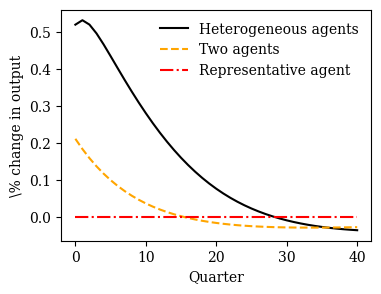

In [ ]:
plt.plot(irfs_B['ha'][:41], label='Heterogeneous agents', color='black')
plt.plot(irfs_B['ta'][:41], label='Two agents', linestyle='dashed', color='orange')
plt.plot(irfs_B['ra'][:41], label='Representative agent', linestyle='dashdot', color='red')
plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('\% change in output')
plt.savefig('figures/figure2a_deficit_by_model.pdf', bbox_inches='tight')

#### Comment
Our replication of Figure 2 (a) clearly highlights how the effects of a deficit-financed tax cut differ across the three macroeconomic frameworks. The heterogeneous-agent (HA) model generates the strongest and most persistent output response. Output rises sharply on impact and then declines only gradually over many quarters. This persistence reflects the interaction between high-MPC households, who spend a large share of the tax cut immediately, and wealthy households, who accumulate the additional public debt as savings and spend it only slowly over time. This gradual adjustment of balance sheets sustains aggregate demand well beyond the initial shock. 

The two-agent (TA) model displays a positive but noticeably weaker response. Hand-to-mouth households create an initial boost, but the absence of richer heterogeneity limits the strength of feedback between consumption, income and wealth accumulation. 

By contrast, the representative-agent (RA) model exhibits essentially no response. This is consistent with Ricardian equivalence: households perfectly anticipate future taxes and therefore do not change consumption. 

Overall, the replication confirms that heterogeneity, especially the distribution of marginal propensities to consume, is essential for transforming a temporary tax cut into a prolonged macroeconomic expansion.

#### EXTRA MODEL 1 - IRF of "inequalities" ACROSS models: HA − RA and HA − TA
In this section we compute and plot the Impulse Response Functions (IRFs)
of *inequality* across different macroeconomic models: HA (Heterogeneous
Agents), RA (Representative Agent), and TA (Two-Agent).

What we are doing here:
- The HA model produces an inequality measure (Var(a)) through our new a² output that captures the wealth distribution.
- The RA and TA models do NOT generate inequality endogenously, but they do produce an implied response of aggregate assets. We therefore compare how the HA model's inequality response differs from the RA and TA benchmarks.

Why we compute differences (HA – RA and HA – TA):
- This highlights how much additional distributional dynamics the HA model introduces relative to simpler models.
- A positive difference means inequality reacts *more strongly* in the HA model.
- A negative difference means the HA model generates a weaker response.

Interpretation of the plot:
- Each curve shows the dynamic gap in inequality responses after a macroeconomic shock (e.g., monetary or fiscal).
- If the HA curve diverges from RA or TA, it shows that heterogeneity fundamentally changes how inequality evolves after policy shocks.


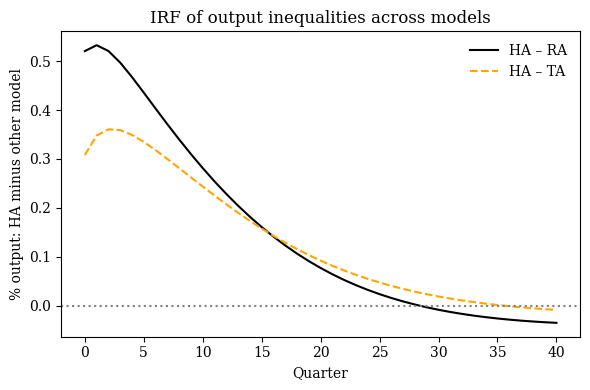

In [ ]:

h = 41
quarters = np.arange(h)

# IRF of inequalities - differences between models' output responses
irf_ha_minus_ra = irfs_B['ha'][:h] - irfs_B['ra'][:h]
irf_ha_minus_ta = irfs_B['ha'][:h] - irfs_B['ta'][:h]

plt.figure(figsize=(6, 4))
plt.plot(quarters, irf_ha_minus_ra, label='HA – RA', color='black')
plt.plot(quarters, irf_ha_minus_ta, label='HA – TA', linestyle='dashed', color='orange')
plt.axhline(0, linestyle='dotted', color='gray')

plt.xlabel('Quarter')
plt.ylabel('% output: HA minus other model')
plt.legend(frameon=False)
plt.title('IRF of output inequalities across models')

plt.tight_layout()
plt.savefig('figures/figure2b_irf_inequalities_across_models.pdf', bbox_inches='tight')
plt.show()


#### Comment
The figure plots the difference in output responses between the HA model and the RA and TA models following the deficit shock. The HA–RA line (black) rises sharply in the first few quarters, reaching a peak slightly above 0.5%. This reflects the stronger short-run expansion generated by the heterogeneous-agent model. After the peak, the difference declines steadily and approaches zero toward the end of the 40-quarter horizon, as the effects of the fiscal shock dissipate across all models. 

The HA–TA line (yellow, dashed) follows a similar pattern but with a lower peak and an earlier decline. This indicates that the two-agent model captures part of the amplification mechanism present in the HA framework, particularly through hand-to-mouth households, but it still produces a weaker and less persistent response than the fully heterogeneous model. Both curves converge toward zero as the economy returns to steady state. 

Overall, the figure shows that the HA model delivers a larger short-run output expansion than either the RA or TA models, underlining the role of household heterogeneity in shaping fiscal multipliers. 

This figure is therefore useful to:
1. Visualize the added value of the HANK structure,
2. Demonstrate the importance of our new inequality moment (a²),
3. Compare policy transmission across models with different levels of household heterogeneity.

#### EXTRA MODEL 2 - IRF of inequality WITHIN the HA model: variance of assets
Now, we compute how *wealth inequality inside the HA model* responds to a deficit-financed fiscal shock, using the variance of assets Var(a) as our inequality measure.

What we do step by step:
1. We solve for the full impulse response of the HA model (irfs_ha_all) without restricting the outputs, so we can access all endogenous variables, including our new second moment a^2.

2. We automatically detect which IRF key corresponds to the second moment of assets (a^2). This makes the code robust even if the variable name changes (e.g. 'a2', 'A2', etc.).

3. Using the steady-state aggregate assets A_ss and second moment A2_ss, we compute the steady-state variance of assets.

4. From the linearized IRFs for A and A^2, we construct the IRF of the *variance* using the first-order approximation (the derivative of Var(a) with respect to E[a] and E[a^2]).

5. We express Var_hat as a percentage deviation from its steady-state level Var_ss. This gives a clear measure of how much wealth inequality moves in response to the shock.

6. Finally, we plot the IRF of Var(assets) over time.

Available HA IRF keys: dict_keys(['B', 'Y', 'N', 'wN', 'div', 'T', 'tax_rate', 'wN_aftertax', 'div_aftertax', 'tax_rate_res', 'T_res', 'constant_owed_res', 'r_post_equity', 'cap_cond', 'p', 'r', 'nkpc_res', 'asset_mkt', 'goods_mkt', 'A', 'C', 'A2'])
Using 'A2' as the second-moment (a^2) variable.


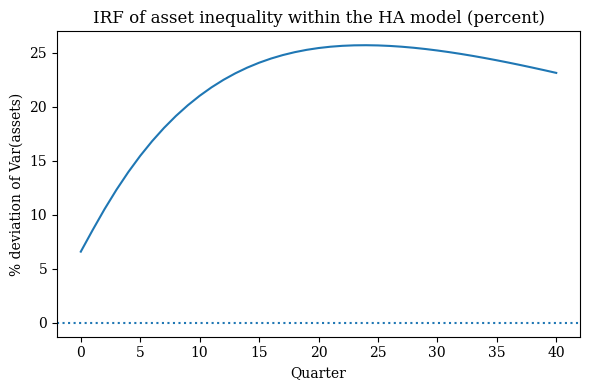

In [48]:

# 1. Get ALL outputs from the HA model's impulse response (no 'outputs' argument)
irfs_ha_all = models['ha'].solve_impulse_linear(
    ss['ha'],
    unknowns=['Y'],
    targets=['asset_mkt'],
    inputs={'B': dB},
    Js=Js
)

print("Available HA IRF keys:", irfs_ha_all.keys())

# 1b. Detect the second-moment variable linked to a^2 automatically
possible_a2_keys = [
    k for k in irfs_ha_all.keys()
    if 'a2' in k.lower() or (('a' in k.lower()) and ('2' in k))
]

if not possible_a2_keys:
    raise KeyError(
        f"No candidate key for a^2 found in HA IRFs. "
        f"Available keys: {list(irfs_ha_all.keys())}"
    )

a2_key = possible_a2_keys[0]
print(f"Using '{a2_key}' as the second-moment (a^2) variable.")

# 2. Steady-state moments of assets
A_ss   = ss['ha']['A']          # steady-state aggregate assets
A2_ss  = ss['ha'][a2_key]       # steady-state second moment of assets
Var_ss = A2_ss - A_ss**2        # steady-state variance of assets

# 3. IRFs (deviations) of the moments from solve_impulse_linear
A_hat  = irfs_ha_all['A']
A2_hat = irfs_ha_all[a2_key]

# 4. Linearised deviation of the variance:
Var_hat = A2_hat - 2 * A_ss * A_hat

# 5. Express in percent deviation from steady-state variance
Var_pct = (Var_hat / Var_ss) * 100

# 6. Plot the within-HA inequality IRF
h = 41
quarters = np.arange(h)

plt.figure(figsize=(6, 4))
plt.plot(quarters, Var_pct[:h])
plt.axhline(0, linestyle='dotted')
plt.xlabel('Quarter')
plt.ylabel('% deviation of Var(assets)')
plt.title('IRF of asset inequality within the HA model (percent)')
plt.tight_layout()
plt.savefig('figures/figure2c_irf_inequality_within_HA.pdf', bbox_inches='tight')
plt.show()



#### Comment
The figure reports the percentage deviation of the variance of assets in the HA model after the deficit-financed tax cut. The curve increases steadily during the first twenty quarters, reaching a peak of about 26%, and then declines slightly while remaining well above its initial level. This pattern indicates that wealth inequality rises meaningfully and remains elevated for a prolonged period following the fiscal shock. 

The rise in dispersion reflects differences in households' saving behavior. High-MPC households consume most of the additional income and experience only limited changes in their asset positions. In contrast, wealthier households save a sizeable share of the tax cut and absorb the newly issued government debt. As these savings accumulate over time, the distribution of assets spreads out, leading to a higher variance of wealth. 

Overall, the IRF shows that the fiscal expansion not only stimulates aggregate activity but also has persistent distributional effects. The widening of asset inequality is a direct consequence of the heterogeneous responses of households to the shock. 

### 3(ii). Alternative assumptions and policy rules
We now perform, in the same order they are listed, the alternative experiments in Figure 2(b) and Figure 4(b), 

#### Tax changes at margin on highest earners

In [26]:
# replace regular fiscal rule with rule that taxes the richest at the margin
common_blocks_richest = common_blocks.copy()
common_blocks_richest[2] = fiscal_richest
model_ha_richest = sj.combine(common_blocks_richest + [hh_ha])

irf_B_richest = model_ha_richest.solve_impulse_linear(ss['ha'], unknowns=['Y'], targets=['asset_mkt'],
                                                      inputs={'B': dB}, outputs=['Y'])['Y']

#### Taylor rule
For this rule, we need to calculate inflation `pi` as an additional unknown, adding the NKPC residual as an additional target. We also need to add the `taylor_rule` block to the model, specifying its additional parameters.

In [27]:
ss_taylor = ss['ha'].copy()
ss_taylor['phi'], ss_taylor['rstar'] = 1.5, r
model_ha_taylor = sj.combine(common_blocks + [hh_ha, taylor_rule])
irf_B_taylor = model_ha_taylor.solve_impulse_linear(ss_taylor, unknowns=['Y', 'pi'], targets=['asset_mkt', 'nkpc_res'],
                                               inputs={'B': dB}, outputs=['Y'], Js=Js)['Y']

#### Angeletos-Lian-Wolf tax rate rule
For this rule, total debt $B$ is endogenously determined subject to a rule that sets the tax rate equal to the steady state plus some shock (which we enforce by setting the previously defined `tax_rate_res` residual to zero):

In [28]:
irf_B_ALW = models['ha'].solve_impulse_linear(ss['ha'], unknowns=['Y', 'B'], targets=['asset_mkt', 'tax_rate_res'],
                                             inputs={'tax_rate_shock': dT_shock}, outputs=['Y'], Js=Js)['Y']


#### Figure 2(b)
We summarize the additional results we've obtained so far in Figure 2(b):

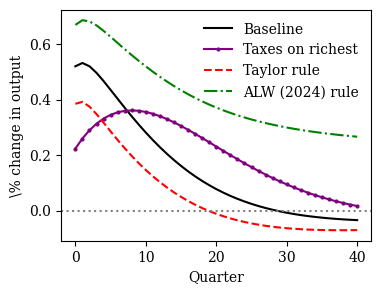

In [29]:
plt.plot(irfs_B['ha'][:41], label='Baseline', color='black')
plt.plot(irf_B_richest[:41], label='Taxes on richest', linestyle='-', color='#800080', marker='o', markersize=2)
plt.plot(irf_B_taylor[:41], label='Taylor rule', linestyle='dashed', color='red')
plt.plot(irf_B_ALW[:41], label='ALW (2024) rule', linestyle='dashdot', color='green')
plt.axhline(y=0, linestyle='dotted', color='gray')

plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('\% change in output')
plt.savefig('figures/figure2b_deficit_alternative_rules.pdf', bbox_inches='tight')

#### Comment on Figure 2(b) 
It shows that the same fiscal shock can produce significantly different macroeconomic responses depending on the fiscal or monetary rule in place. The baseline case reproduces a persistent expansion similar to Figure 2(a). 

Taxing the richest group more heavily dampens the initial response, as the stimulus is shifted toward households with lower MPCs. Yet the subsequent contraction is also milder, because these high-wealth households reduce consumption less when taxes later increase. 

Under a Taylor rule, monetary policy reacts to the fiscal expansion by raising interest rates earlier, which restrains demand and noticeably reduces the size of the output response. 

The ALW (2024) rule produces the most persistent expansion. Because this rule allows the effects of the fiscal shock to accumulate with limited monetary offset, the output response decays more slowly. 

Taken together, the figure shows that the interaction between fiscal and monetary policy critically shapes the overall impact of deficit-financed stimulus. 

#### HANK-FTPL
This combines elements of the Taylor rule case and ALW case above. We now set a Taylor rule coefficient of zero ("passive" monetary policy), replace the previous government debt block with nominal debt, and have bonds $B$ determined endogenously by a rule that exogenously shocks total government tax revenue (and thus primary surpluses).

In [30]:
ss_ftpl = ss_taylor.copy()
ss_ftpl['phi'] = 0
common_blocks_nomdebt = common_blocks.copy()
common_blocks_nomdebt[1] = nom_ST_bonds
model_ha_ftpl = sj.combine(common_blocks_nomdebt + [hh_ha, taylor_rule])
irf_B_FTPL_nomdebt =model_ha_ftpl.solve_impulse_linear(ss_ftpl, unknowns=['Y', 'pi', 'B'],
                                            targets=['asset_mkt', 'nkpc_res', 'T_res'],
                                            inputs={'T_shock': dT_shock}, outputs=['Y'], Js=Js)['Y']


#### Myopic households
We modify our pre-calculated Jacobians by hand to make them "myopic" (so that every shock is treated as a surprise, and has the same reaction as in the 0th column), and then feed these new Jacobians into `Js`:

In [31]:
# Make Jacobians myopic: Copy the first column down along the diagonal
jac_ = {}
for o in ['C', 'A']:
    jac_[o] = {}
    for i in ['wN_aftertax', 'N', 'r']:
        jac_[o][i] = np.tril(scipy.linalg.toeplitz(Js['hh_ha'][o, i][:, 0])) # first column repeated along diagonal
        
Js_myopic = {'hh_ha': sj.JacobianDict(jac_, inputs=['wN_aftertax', 'N', 'r'], outputs=['C', 'A'], name='hh')}

# currently a bug in sequence_jacobian where impulse_linear doesn't pass through Js on hetblocks, will fix ASAP!
# irf_B_myopic = models['ha'].solve_impulse_linear(ss['ha'], unknowns=['Y'], targets=['asset_mkt'],
#                                                 inputs={'B': dB}, Js={'hh': jac_myopic}, outputs=['Y'])['Y']

irf_B_myopic = (models['ha'].solve_jacobian(ss['ha'], unknowns=['Y'], targets=['asset_mkt'], T=T,
                                        Js=Js_myopic, inputs=['B'], outputs=['Y']) @ {'B': dB})['Y']

#### Nonlinear response

In [32]:
# nonlinearity
irf_B_nonlinear = models['ha'].solve_impulse_nonlinear(ss['ha'], unknowns=['Y'], targets=['asset_mkt'],
                                    inputs={'B': dB*0.01}, outputs=['Y'], Js=Js)['Y']*100

Solving real_ST_bonds_to_nkpc_combined for ['Y'] to hit ['asset_mkt']
Solving capitalization_inner for ['p'] to hit ['cap_cond']
On iteration 0
   max error for cap_cond is 8.88E-04
On iteration 1
   max error for cap_cond is 3.55E-15
On iteration 0
   max error for asset_mkt is 3.13E-02
Solving capitalization_inner for ['p'] to hit ['cap_cond']
On iteration 0
   max error for cap_cond is 1.44E-03
On iteration 1
   max error for cap_cond is 3.55E-15
On iteration 1
   max error for asset_mkt is 2.31E-04
Solving capitalization_inner for ['p'] to hit ['cap_cond']
On iteration 0
   max error for cap_cond is 1.45E-03
On iteration 1
   max error for cap_cond is 5.33E-15
On iteration 2
   max error for asset_mkt is 1.53E-06
Solving capitalization_inner for ['p'] to hit ['cap_cond']
On iteration 0
   max error for cap_cond is 1.45E-03
On iteration 1
   max error for cap_cond is 3.55E-15
On iteration 3
   max error for asset_mkt is 3.48E-08
Solving capitalization_inner for ['p'] to hit ['cap_co

#### Figure 4(b)

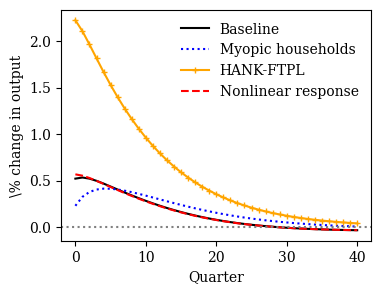

In [33]:
plt.plot(irfs_B['ha'][:41], label='Baseline', color='black')
plt.plot(irf_B_myopic[:41], label='Myopic households', linestyle='dotted', color='blue')
plt.plot(irf_B_FTPL_nomdebt[:41], label='HANK-FTPL', linestyle='-', color='orange', marker='+', markersize=4)
plt.plot(irf_B_nonlinear[:41], label='Nonlinear response', linestyle='dashed', color='red')
plt.axhline(y=0, linestyle='dotted', color='gray')

plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('\% change in output')
plt.savefig('figures/figure4b_deficit_extensions.pdf', bbox_inches='tight')

# 4. Monetary policy shock

First, let's specify our main monetary policy experiment, an exogenous cut to the real interest rate:

In [34]:
dr = -0.25 * 0.9**np.arange(T)
shock_r = {'r_ante': dr}

### 4(i). Baseline monetary policy exercise
First we'll compute impulse responses for our baseline monetary policy exercise.

We choose the fiscal response by setting `constant_owed_res` to zero as a target, which endogenously determines `B` so that, going into the next period, the total real cash flow owed by the government is always constant. We can think of this as a very rapid fiscal response to interest rates:

In [35]:
irfs_r = {k: models[k].solve_impulse_linear(ss[k], unknowns=['Y', 'B'], targets=['asset_mkt', 'constant_owed_res'],
                                inputs=shock_r, outputs=['Y', 'r', 'wN', 'wN_aftertax'], Js=Js) for k in model_names}

#### Figure 3(a)

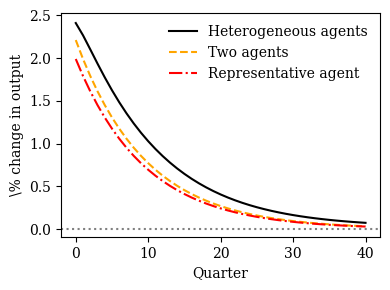

In [36]:
plt.plot(irfs_r['ha']['Y'][:41], label='Heterogeneous agents', color='black')
plt.plot(irfs_r['ta']['Y'][:41], label='Two agents', linestyle='dashed', color='orange')
plt.plot(irfs_r['ra']['Y'][:41], label='Representative agent', linestyle='dashdot', color='red')
plt.axhline(y=0, linestyle='dotted', color='gray')
plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('\% change in output')
plt.tight_layout()
plt.savefig('figures/figure3a_monetary_by_model.pdf')

#### EXTRA MONETARY 1 – Output inequalities ACROSS models (HA − RA / HA − TA)
Here we compare how *monetary policy* affects wealth inequality in the three macroeconomic models with different levels of heterogeneity: HA, RA and TA.

The goal is to isolate the contribution of heterogeneity by computing differences between the HA response and the simplified models: HA – RA   and   HA – TA

What we do:
1. For each model we compute its impulse response to a monetary shock.
2. We extract the inequality-related variable from each model's IRF. In HA this comes from our new a²-based inequality measure.
3. We subtract the RA and TA responses from the HA response to obtain *differences in inequality dynamics* across models.

Why this is useful:
- RA and TA models do not generate meaningful inequality dynamics, so comparing them with HA highlights how much heterogeneity amplifies or dampens inequality responses to monetary policy.

Economic insight:
Monetary policy often affects inequality through:
- the income channel (labor income changes)
- the wealth channel (asset prices respond to interest rates)
- redistribution via government liabilities

Since HA explicitly includes heterogeneous asset and income positions, it produces rich inequality dynamics that are entirely absent in the R, benchmark and only partially present in the TA model.

Plotting HA – RA and HA – TA quantifies this difference directly.

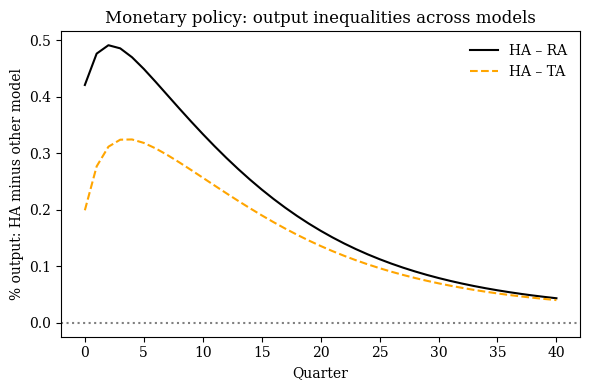

In [ ]:
h = 41
quarters = np.arange(h)

irf_r_ha_minus_ra = irfs_r['ha']['Y'][:h] - irfs_r['ra']['Y'][:h]
irf_r_ha_minus_ta = irfs_r['ha']['Y'][:h] - irfs_r['ta']['Y'][:h]

plt.figure(figsize=(6, 4))
plt.plot(quarters, irf_r_ha_minus_ra, label='HA – RA', color='black')
plt.plot(quarters, irf_r_ha_minus_ta, label='HA – TA', linestyle='dashed', color='orange')
plt.axhline(y=0, linestyle='dotted', color='gray')

plt.xlabel('Quarter')
plt.ylabel('% output: HA minus other model')
plt.title('Monetary policy: output inequalities across models')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('figures/figure3c_monetary_inequalities_across_models.pdf', bbox_inches='tight')
plt.show()


#### Comment
This figure shows how the inequality response to a monetary policy shock differs between the heterogeneous-agent (HA) model and the simpler RA and TA frameworks.

The HA–RA gap (black line) indicates how much more inequality rises (or falls) in the full HANK environment relative to the representative-agent benchmark, which by construction generates no meaningful distributional dynamics. A positive value means monetary policy affects inequality more strongly in the HA model.

The HA–TA difference (yellow dashed line) is typically smaller, since the two-agent model captures part of the redistribution and heterogeneity channels present in the HA model, but still misses the full wealth distribution and MPC heterogeneity.

Overall, the figure highlights that richer heterogeneity in income, wealth, and consumption-smoothing abilities causes the HA model to generate stronger and more realistic inequality responses to monetary policy shocks than its simpler counterparts.

#### EXTRA MONETARY 2 – Inequality WITHIN the HA model (variance of assets)

The purpose of this section is to compute how a *monetary policy shock* affects wealth inequality inside the HA model itself. We measure inequality using the variance of assets:

This complements EXTRA MONETARY 1:
- EXTRA 1 compares HA to RA and TA (across models)
- EXTRA 2 studies inequality dynamics entirely *within* the HA model

Why this matters:
Monetary policy affects both sides of household balance sheets:
- It changes the return on savings (r)
- It affects labor demand, wages, and income risk
- It moves asset prices, redistributing wealth

Only a full HA model with a² can capture these channels. This figure visualizes the net effect of monetary policy on inequality.


Available HA IRF keys (monetary): dict_keys(['r_ante', 'Y', 'N', 'wN', 'div', 'r_post_bonds', 'qbond', 'T', 'tax_rate', 'wN_aftertax', 'div_aftertax', 'tax_rate_res', 'T_res', 'constant_owed_res', 'r_post_equity', 'cap_cond', 'p', 'r', 'nkpc_res', 'asset_mkt', 'goods_mkt', 'A', 'C', 'A2'])
Using 'A2' as the second-moment (a^2) variable for monetary policy.


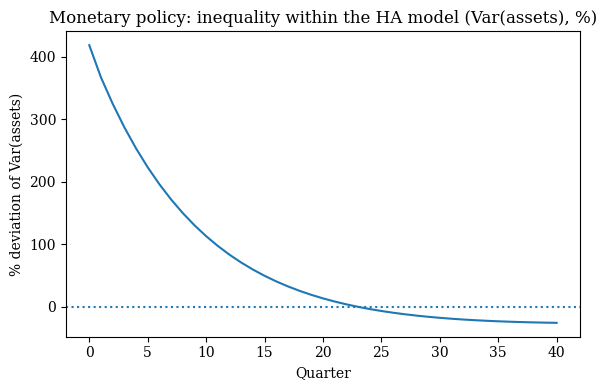

In [ ]:
# 1. Get ALL outputs from the HA model's monetary-policy impulse response
irfs_ha_r_all = models['ha'].solve_impulse_linear(
    ss['ha'],
    unknowns=['Y'],
    targets=['asset_mkt'],
    inputs=shock_r,   # <-- we use the shock of r, not of B
    Js=Js
)

print("Available HA IRF keys (monetary):", irfs_ha_r_all.keys())

# 1b. Detect the second-moment variable linked to a^2 automatically
possible_a2_keys = [
    k for k in irfs_ha_r_all.keys()
    if 'a2' in k.lower() or (('a' in k.lower()) and ('2' in k))
]

if not possible_a2_keys:
    raise KeyError(
        f"No candidate key for a^2 found in HA IRFs (monetary). "
        f"Available keys: {list(irfs_ha_r_all.keys())}"
    )

a2_key_r = possible_a2_keys[0]
print(f"Using '{a2_key_r}' as the second-moment (a^2) variable for monetary policy.")

# 2. Steady-state moments of assets
A_ss   = ss['ha']['A']            # steady-state aggregate assets
A2_ss  = ss['ha'][a2_key_r]       # steady-state second moment of assets
Var_ss = A2_ss - A_ss**2          # steady-state variance of assets

# 3. IRFs (deviations) of the moments from solve_impulse_linear (monetary)
A_hat_r  = irfs_ha_r_all['A']
A2_hat_r = irfs_ha_r_all[a2_key_r]

# 4. Linearised deviation of the variance:
#    Var_hat_t = m2_hat_t - 2 * A_ss * A_hat_t  (first-order approx)
Var_hat_r = A2_hat_r - 2 * A_ss * A_hat_r

# 5. Express in percent deviation from steady-state variance
Var_pct_r = (Var_hat_r / Var_ss) * 100

# 6. Plot the within-HA inequality IRF for monetary policy
h = 41
quarters = np.arange(h)

plt.figure(figsize=(6, 4))
plt.plot(quarters, Var_pct_r[:h])
plt.axhline(0, linestyle='dotted')
plt.xlabel('Quarter')
plt.ylabel('% deviation of Var(assets)')
plt.title('Monetary policy: inequality within the HA model (Var(assets), %)')
plt.tight_layout()
plt.savefig('figures/figure3d_monetary_inequality_within_HA.pdf', bbox_inches='tight')
plt.show()


#### Comment 
The figure shows how wealth inequality within the HA model responds to a monetary policy shock. On impact, the variance of assets jumps by more than 400%, indicating that lower interest rates raise asset prices and disproportionately benefit wealthier households. This sharp increase reflects the strong redistribution embedded in the heterogeneous-agent structure: asset-rich households experience capital gains that far exceed those of low-wealth households.

After the initial spike, the effect decreases gradually but remains positive for roughly 20 quarters, showing that monetary easing has a highly persistent impact on the dispersion of wealth. Only in the very long run does the variance return toward its steady-state level.

This pattern illustrates a central implication of HANK models: even when monetary policy stimulates aggregate activity, it can simultaneously widen wealth inequality through asset-price channels.

#### Figure 3(b): decomposition
Now, we use the household Jacobians we've calculated to get contributions to consumption (and, in this case, therefore output) from all individual sources.

First, the "capital gains" effect is the response to the unexpected change in ex-post $r_0$, while the effect of ex-ante interest rates corresponds to the change in ex-post $\{r_1,r_2,\ldots\}$. Then 

In [39]:
dC_cap_gains = Js['hh_ha']['C','r'][:, 0] * irfs_r['ha']['r'][0]
dC_r = Js['hh_ha']['C','r'][:, 1:] @ irfs_r['ha']['r'][1:]
dC_labor = Js['hh_ha']['C', 'wN_aftertax'] @ irfs_r['ha']['wN']
dC_tax = Js['hh_ha']['C', 'wN_aftertax'] @ (irfs_r['ha']['wN_aftertax'] - irfs_r['ha']['wN'])
assert np.allclose(dC_cap_gains + dC_r + dC_labor + dC_tax, irfs_r['ha']['Y'])

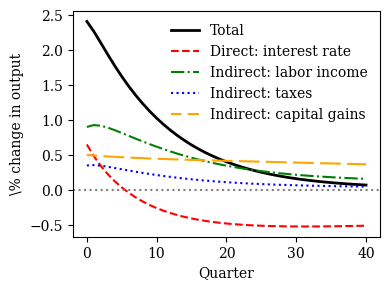

In [40]:
plt.plot(irfs_r['ha']['Y'][:41], label='Total', color='black', linewidth=2)
plt.plot(dC_r[:41], label='Direct: interest rate', linestyle='dashed', color='red')
plt.plot(dC_labor[:41], label='Indirect: labor income', linestyle='dashdot', color='green')
plt.plot(dC_tax[:41], label='Indirect: taxes', linestyle='dotted', color='blue')
plt.plot(dC_cap_gains[:41], label='Indirect: capital gains', linestyle=(5, (10, 3)), color='orange')
plt.axhline(y=0, linestyle='dotted', color='gray')
plt.legend(frameon=False)
plt.tight_layout()
plt.xlabel('Quarter')
plt.ylabel('\% change in output')
plt.tight_layout()
plt.savefig('figures/figure3b_monetary_decomposition.pdf')

### 4(ii). Alternative assumptions for monetary policy

#### Slow fiscal adjustment
We implement slow fiscal adjustment by instead targeting the `T_res` residual of a rule that adjusts taxes by a small amount in response to debt being away from steady state:

In [41]:
ss_slow = ss['ha'].copy()
ss_slow['T_rule_coeff'] = 0.02
irf_r_altfiscal = models['ha'].solve_impulse_linear(ss_slow, unknowns=['Y', 'B'], targets=['asset_mkt', 'T_res'],
                                                    inputs=shock_r, outputs=['Y'], Js=Js)['Y']

#### Long-term debt
To implement long-term debt (still real), we replace the relevant government bond block by `real_LT_bonds` and regenerate the model.

In [42]:
common_blocks_LTdebt = common_blocks.copy()
common_blocks_LTdebt[1] = real_LT_bonds
model_ha_LTdebt = sj.combine(common_blocks_LTdebt + [hh_ha])

# recalculate steady state to get correct qbond
ss_LTdebt = model_ha_LTdebt.steady_state({**ss['ha'], 'delta': 0.95})
assert np.allclose([ss_LTdebt['asset_mkt'], ss_LTdebt['goods_mkt'], ss_LTdebt['nkpc_res']], [0, 0, 0], atol=1e-6)

irf_r_LTdebt = model_ha_LTdebt.solve_impulse_linear(ss_LTdebt, unknowns=['Y', 'B'], 
                        targets=['asset_mkt', 'constant_owed_res'], inputs=shock_r, outputs=['Y'], Js=Js)['Y']

#### Nominal debt
We have already implemented nominal (short-term) debt as part of our FTPL exercise. We'll reuse the `common_blocks_nomdebt` from that exercise, and similarly solve for both `B` and `pi` in addition to `Y` as unknowns. (Now, however, we are back to our standard "constant owed tomorrow" fiscal rule.)

In [43]:
# replace bond return function
model_ha_nomdebt = sj.combine(common_blocks_nomdebt + [hh_ha])
irf_r_nomdebt = model_ha_nomdebt.solve_impulse_linear(ss['ha'], unknowns=['Y', 'B', 'pi'],
                    targets=['asset_mkt', 'constant_owed_res', 'nkpc_res'], inputs=shock_r, outputs=['Y'], Js=Js)['Y']

### Alternative cyclicality of income
Note: here, the results differ from the October 2024 working paper version of the paper, since there was a mistake in the definition of `gamma_N` in the `income` function of `household.py` where the $\gamma$ function was not properly normalized. Countercyclical risk still amplifies the response, but less so than before at $\zeta=-0.15$. Many thanks to Nicolai Waldstrøm for the catch!

In [44]:
ss_countercyc = ss['ha'].copy()
ss_countercyc['zeta'] = -0.15 # don't use precalculated Js here, since zeta != 0 should change them
irf_r_countercyc = models['ha'].solve_impulse_linear(ss_countercyc, unknowns=['Y', 'B'], targets=['asset_mkt', 'constant_owed_res'], inputs=shock_r, outputs=['Y'])['Y']

### Plot results

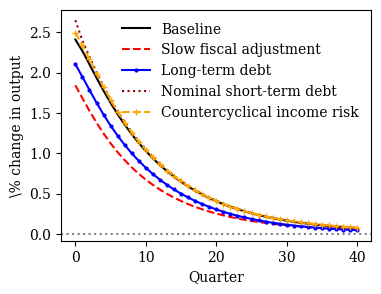

In [45]:
plt.plot(irfs_r['ha']['Y'][:41], label='Baseline', color='black')
plt.plot(irf_r_altfiscal[:41], label='Slow fiscal adjustment', linestyle='dashed', color='red')
plt.plot(irf_r_LTdebt[:41], label='Long-term debt',  linestyle='-', color='blue', marker='o', markersize=2)
plt.plot(irf_r_nomdebt[:41], label='Nominal short-term debt',  linestyle='dotted', color='darkred')
plt.plot(irf_r_countercyc[:41], label='Countercyclical income risk', linestyle='dashed', color='orange', marker='+', markersize=4)

plt.axhline(y=0, linestyle='dotted', color='gray')

plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('\% change in output')
plt.savefig('figures/figure4a_monetary_extensions.pdf', bbox_inches='tight')